In [1]:
import os
from datetime import datetime, date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
if pathlib.Path("../data/employees.csv").exists():
    employees = pd.read_csv("../data/employees.csv", parse_dates=["hire_date"])
if pathlib.Path("../data/plans.csv").exists():
    plans = pd.read_csv("../data/plans.csv")


plt.style.use("seaborn-v0_8")
os.makedirs("../outputs/figures", exist_ok=True)
os.makedirs("../outputs/reports", exist_ok=True)

RUN_TS = datetime.now().strftime("%Y-%m-%d_%H%M%S")


In [2]:
np.random.seed(42)
n = 50
employees = pd.DataFrame({
    "employee_id": range(1001, 1001+n),
    "name": [f"Employee {i}" for i in range(1, n+1)],
    "department": np.random.choice(["Engineering","HR","Finance","Operations","Sales"], size=n, p=[0.3,0.1,0.15,0.25,0.2]),
    "salary": np.random.choice([45000, 60000, 80000, 120000], size=n, p=[0.3,0.35,0.25,0.1]),
    "hire_date": pd.to_datetime(np.random.choice(pd.date_range("2023-01-01","2025-07-01"), size=n)),
    "status": np.random.choice(["Full-time","Part-time"], size=n, p=[0.8,0.2]),
    "age": np.random.randint(21, 65, size=n),
    "num_dependents": np.random.choice([0,1,2,3], size=n, p=[0.5,0.25,0.2,0.05]),
})
employees["has_dependents"] = employees["num_dependents"] > 0
employees.head()


,employee_id,name,department,salary,hire_date,status,age,num_dependents,has_dependents
0,1001,Employee 1,HR,120000,2024-07-28,Full-time,60,0,False
1,1002,Employee 2,Sales,80000,2025-05-13,Full-time,21,0,False
2,1003,Employee 3,Operations,120000,2025-01-12,Full-time,31,0,False
3,1004,Employee 4,Operations,80000,2023-08-29,Full-time,48,1,True
4,1005,Employee 5,Engineering,60000,2024-07-17,Full-time,45,1,True


In [3]:
plans = pd.DataFrame([
    {"plan_id":"HMO_BASIC", "name":"HMO Basic", "type":"Health", "coverage":"HMO",
     "employee_premium_base": 120.0, "employer_premium": 300.0, "deductible": 2000, "dep_factor": 0.20,
     "match_rate": np.nan, "max_match_pct": np.nan, "wellness_credit": 0.0},
    {"plan_id":"PPO_PLUS", "name":"PPO Plus", "type":"Health", "coverage":"PPO",
     "employee_premium_base": 220.0, "employer_premium": 420.0, "deductible": 1000, "dep_factor": 0.22,
     "match_rate": np.nan, "max_match_pct": np.nan, "wellness_credit": 0.0},
    {"plan_id":"RET_401K", "name":"401(k)", "type":"Retirement", "coverage":None,
     "employee_premium_base": np.nan, "employer_premium": np.nan, "deductible": np.nan, "dep_factor": np.nan,
     "match_rate": 0.50, "max_match_pct": 0.05, "wellness_credit": 0.0},
    {"plan_id":"WELLNESS", "name":"Wellness Program", "type":"Wellness", "coverage":None,
     "employee_premium_base": 0.0, "employer_premium": 20.0, "deductible": np.nan, "dep_factor": np.nan,
     "match_rate": np.nan, "max_match_pct": np.nan, "wellness_credit": 20.0},
])
plans


,plan_id,name,type,coverage,employee_premium_base,employer_premium,deductible,dep_factor,match_rate,max_match_pct,wellness_credit
0,HMO_BASIC,HMO Basic,Health,HMO,120.0,300.0,2000.0,0.20,NaN,NaN,0.0
1,PPO_PLUS,PPO Plus,Health,PPO,220.0,420.0,1000.0,0.22,NaN,NaN,0.0
2,RET_401K,401(k),Retirement,None,NaN,NaN,NaN,NaN,0.5,0.05,0.0
3,WELLNESS,Wellness Program,Wellness,None,0.0,20.0,NaN,NaN,NaN,NaN,20.0


In [4]:
today = pd.to_datetime("today").normalize()
open_enrollment_start = pd.to_datetime("2025-08-01")
open_enrollment_end   = pd.to_datetime("2025-09-15")

def in_open_enrollment(day):
    return (day >= open_enrollment_start) & (day <= open_enrollment_end)

def eligible_health(row):
    days = (today - row["hire_date"]).days
    return (row["status"] == "Full-time") and (days >= 30)

def eligible_retirement(row):
    days = (today - row["hire_date"]).days
    return (row["age"] >= 18) and (days >= 90)

def eligible_wellness(row):
    return True

employees["elig_health"] = employees.apply(eligible_health, axis=1)
employees["elig_retire"] = employees.apply(eligible_retirement, axis=1)
employees["elig_well"]   = employees.apply(eligible_wellness, axis=1)
employees.head()


,employee_id,name,department,salary,hire_date,status,age,num_dependents,has_dependents,elig_health,elig_retire,elig_well
0,1001,Employee 1,HR,120000,2024-07-28,Full-time,60,0,False,True,True,True
1,1002,Employee 2,Sales,80000,2025-05-13,Full-time,21,0,False,True,True,True
2,1003,Employee 3,Operations,120000,2025-01-12,Full-time,31,0,False,True,True,True
3,1004,Employee 4,Operations,80000,2023-08-29,Full-time,48,1,True,True,True,True
4,1005,Employee 5,Engineering,60000,2024-07-17,Full-time,45,1,True,True,True,True


In [5]:
def choose_health_plan(row):
    if not row["elig_health"]: 
        return None
    return "PPO_PLUS" if row["salary"] >= 80000 else "HMO_BASIC"

def choose_retirement_contrib(row):
    if not row["elig_retire"]:
        return 0.0
    pct = np.clip(np.random.normal(0.05, 0.01), 0.03, 0.06)
    return round(row["salary"] * pct / 12.0, 2)

def choose_wellness(row):
    return row["elig_well"] and (np.random.rand() < 0.7)

enroll = employees.copy()
enroll["health_plan_id"] = enroll.apply(choose_health_plan, axis=1)
enroll["retire_contrib_monthly"] = enroll.apply(choose_retirement_contrib, axis=1)
enroll["wellness_enrolled"] = enroll.apply(choose_wellness, axis=1)
enroll.head()


,employee_id,name,department,salary,hire_date,status,age,num_dependents,has_dependents,elig_health,elig_retire,elig_well,health_plan_id,retire_contrib_monthly,wellness_enrolled
0,1001,Employee 1,HR,120000,2024-07-28,Full-time,60,0,False,True,True,True,PPO_PLUS,544.98,True
1,1002,Employee 2,Sales,80000,2025-05-13,Full-time,21,0,False,True,True,True,PPO_PLUS,400.00,True
2,1003,Employee 3,Operations,120000,2025-01-12,Full-time,31,0,False,True,True,True,PPO_PLUS,433.31,True
3,1004,Employee 4,Operations,80000,2023-08-29,Full-time,48,1,True,True,True,True,PPO_PLUS,220.55,False
4,1005,Employee 5,Engineering,60000,2024-07-17,Full-time,45,1,True,True,True,True,HMO_BASIC,282.84,True


In [6]:
plan_map = plans.set_index("plan_id").to_dict(orient="index")
wellness_credit = plans.loc[plans["plan_id"]=="WELLNESS","wellness_credit"].iloc[0]

def calc_health_costs(row):
    pid = row["health_plan_id"]
    if pid is None:
        return pd.Series({"emp_health":0.0,"er_health":0.0,"deductible":0.0})
    p = plan_map[pid]
    emp = p["employee_premium_base"] * (1 + p["dep_factor"] * row["num_dependents"])
    if row["wellness_enrolled"]:
        emp = max(0.0, emp - wellness_credit)
    er = p["employer_premium"]
    return pd.Series({"emp_health": round(emp,2), "er_health": round(er,2), "deductible": p["deductible"]})

def calc_retirement_match(row):
    if row["retire_contrib_monthly"] <= 0:
        return 0.0
    p = plan_map["RET_401K"]
    max_match_amt = (row["salary"] * p["max_match_pct"]) / 12.0
    match = min(row["retire_contrib_monthly"], max_match_amt) * p["match_rate"]
    return round(match, 2)

costs = enroll.apply(calc_health_costs, axis=1)
enroll = pd.concat([enroll, costs], axis=1)
enroll["er_retire_match"] = enroll.apply(calc_retirement_match, axis=1)
enroll["emp_total_monthly"] = enroll["emp_health"] + enroll["retire_contrib_monthly"]
enroll["er_total_monthly"]  = enroll["er_health"] + enroll["er_retire_match"]
enroll.sample(5)


,employee_id,name,department,salary,hire_date,status,age,num_dependents,has_dependents,elig_health,...,elig_well,health_plan_id,retire_contrib_monthly,wellness_enrolled,emp_health,er_health,deductible,er_retire_match,emp_total_monthly,er_total_monthly
30,1031,Employee 31,Operations,80000,2024-09-11,Full-time,28,0,False,True,...,True,PPO_PLUS,300.92,False,220.0,420.0,1000.0,150.46,520.92,570.46
1,1002,Employee 2,Sales,80000,2025-05-13,Full-time,21,0,False,True,...,True,PPO_PLUS,400.00,True,200.0,420.0,1000.0,166.67,600.00,586.67
5,1006,Employee 6,Engineering,120000,2023-04-06,Full-time,43,0,False,True,...,True,PPO_PLUS,356.41,True,200.0,420.0,1000.0,178.21,556.41,598.21
7,1008,Employee 8,Sales,45000,2025-01-03,Full-time,50,1,True,True,...,True,HMO_BASIC,143.13,False,144.0,300.0,2000.0,71.56,287.13,371.56
14,1015,Employee 15,Engineering,45000,2024-06-24,Full-time,21,0,False,True,...,True,HMO_BASIC,162.16,True,100.0,300.0,2000.0,81.08,262.16,381.08


In [7]:
assert enroll["emp_total_monthly"].ge(0).all()
assert enroll["er_total_monthly"].ge(0).all()
assert enroll["retire_contrib_monthly"].ge(0).all()
assert enroll["emp_health"].ge(0).all()

assert enroll.loc[~enroll["elig_health"], "health_plan_id"].isna().all()

summary = {
    "employees": len(enroll),
    "health_enrolled": enroll["health_plan_id"].notna().sum(),
    "retirement_contributors": (enroll["retire_contrib_monthly"] > 0).sum(),
    "wellness_enrolled": enroll["wellness_enrolled"].sum(),
}
summary


{'employees': 50,
 'health_enrolled': np.int64(42),
 'retirement_contributors': np.int64(49),
 'wellness_enrolled': np.int64(36)}

In [8]:
dept = enroll.groupby("department").agg(
    emp_cost=("emp_total_monthly","sum"),
    er_cost=("er_total_monthly","sum"),
    headcount=("employee_id","count"),
    health_enrolled=("health_plan_id", lambda s: s.notna().sum()),
).reset_index()
dept["emp_cost_per_capita"] = (dept["emp_cost"] / dept["headcount"]).round(2)
dept["er_cost_per_capita"]  = (dept["er_cost"] / dept["headcount"]).round(2)
dept.sort_values("er_cost", ascending=False)


,department,emp_cost,er_cost,headcount,health_enrolled,emp_cost_per_capita,er_cost_per_capita
0,Engineering,7149.90,7448.06,19,16,376.31,392.00
3,Operations,4619.42,5110.80,10,10,461.94,511.08
1,Finance,3290.15,3134.37,8,6,411.27,391.80
4,Sales,2863.10,2962.17,8,6,357.89,370.27
2,HR,2346.01,2325.52,5,4,469.20,465.10


C:\Users\user\AppData\Local\Temp\ipykernel_4312\3415055256.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept.sort_values("er_cost", ascending=False), x="department", y="er_cost", ax=axes[0], palette="Blues_d")
C:\Users\user\AppData\Local\Temp\ipykernel_4312\3415055256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=enroll.dropna(subset=["health_plan_id"]), x="health_plan_id", y="emp_health", ax=axes[1], palette="Greens_d")


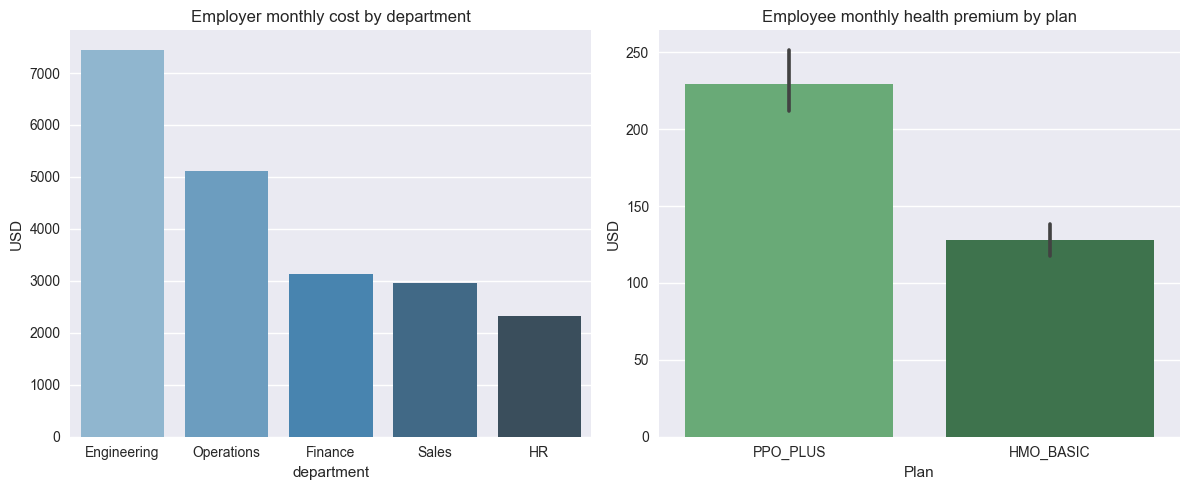

'../outputs/figures/costs_2025-08-20_112521.png'

<Figure size 800x550 with 0 Axes>

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.barplot(data=dept.sort_values("er_cost", ascending=False), x="department", y="er_cost", ax=axes[0], palette="Blues_d")
axes[0].set_title("Employer monthly cost by department")
axes[0].set_ylabel("USD")

sns.barplot(data=enroll.dropna(subset=["health_plan_id"]), x="health_plan_id", y="emp_health", ax=axes[1], palette="Greens_d")
axes[1].set_title("Employee monthly health premium by plan")
axes[1].set_xlabel("Plan")
axes[1].set_ylabel("USD")
plt.tight_layout()
plt.show()

fig_path = f"../outputs/figures/costs_{RUN_TS}.png"
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
fig_path


In [10]:
enroll_out = enroll[[
    "employee_id","name","department","salary","status","age","num_dependents",
    "health_plan_id","emp_health","er_health","deductible",
    "retire_contrib_monthly","er_retire_match",
    "wellness_enrolled","emp_total_monthly","er_total_monthly"
]].sort_values(["department","name"])

dept_out = dept.sort_values("er_cost", ascending=False)

enroll_csv = f"../outputs/reports/enrollments_{RUN_TS}.csv"
dept_csv   = f"../outputs/reports/dept_summary_{RUN_TS}.csv"
enroll_out.to_csv(enroll_csv, index=False)
dept_out.to_csv(dept_csv, index=False)

enroll_csv, dept_csv


('../outputs/reports/enrollments_2025-08-20_112521.csv',
 '../outputs/reports/dept_summary_2025-08-20_112521.csv')

In [11]:
if not in_open_enrollment(today):
    enroll["health_plan_id"] = np.where(
        enroll["health_plan_id"].notna(), "PENDING_"+enroll["health_plan_id"].astype(str), enroll["health_plan_id"]
    )
enroll.head()


,employee_id,name,department,salary,hire_date,status,age,num_dependents,has_dependents,elig_health,...,elig_well,health_plan_id,retire_contrib_monthly,wellness_enrolled,emp_health,er_health,deductible,er_retire_match,emp_total_monthly,er_total_monthly
0,1001,Employee 1,HR,120000,2024-07-28,Full-time,60,0,False,True,...,True,PPO_PLUS,544.98,True,200.0,420.0,1000.0,250.00,744.98,670.00
1,1002,Employee 2,Sales,80000,2025-05-13,Full-time,21,0,False,True,...,True,PPO_PLUS,400.00,True,200.0,420.0,1000.0,166.67,600.00,586.67
2,1003,Employee 3,Operations,120000,2025-01-12,Full-time,31,0,False,True,...,True,PPO_PLUS,433.31,True,200.0,420.0,1000.0,216.66,633.31,636.66
3,1004,Employee 4,Operations,80000,2023-08-29,Full-time,48,1,True,True,...,True,PPO_PLUS,220.55,False,268.4,420.0,1000.0,110.28,488.95,530.28
4,1005,Employee 5,Engineering,60000,2024-07-17,Full-time,45,1,True,True,...,True,HMO_BASIC,282.84,True,124.0,300.0,2000.0,125.00,406.84,425.00
